In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
from numpy import array
from numpy import nanmean
import numpy as np
from keras.models import Sequential
from statsmodels.tsa.ar_model import AutoReg
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
import math
from shutil import copyfile
import warnings
warnings.filterwarnings('ignore')
#tf.random.set_seed(7)
#tf.random.set_seed(77)

In [2]:
from shutil import copyfile
copyfile('icecon.APPX.250x250.nc', 'icecon.APPX.250x250.RMSE.MLP_vs_AR.nc')
nc_f    = './icecon.APPX.250x250.RMSE.MLP_vs_AR.nc'
#nc_f    = './icecon.APPX.250x250.1982-2017.nc'
nc_fid  = Dataset(nc_f, 'r+')
time    = nc_fid.variables['record'][:]
sic     = nc_fid.variables['icecon'][:]
RMSE_ML = sic[0,:,:]
RMSE_AR = sic[1,:,:]
RMSE_ML_AR = sic[2,:,:]
n_steps = 12

In [3]:
print(nc_fid.dimensions)
#print(nc_fid.variables.keys())
print(sic.shape)
print(time.shape)

{'record': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'record', size = 444, 'num_pixels': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_pixels', size = 37, 'num_lines': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_lines', size = 37, 'ncl3': <class 'netCDF4._netCDF4.Dimension'>: name = 'ncl3', size = 444}
(444, 37, 37)
(444,)


In [4]:
nmonth  = len(time)
sic_train       =  sic[0:nmonth-12,:,:]
time_train      = time[0:nmonth-12]

False


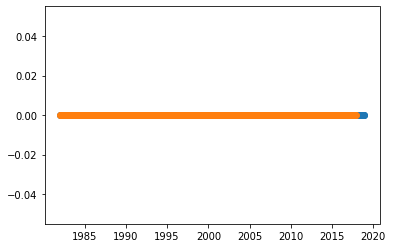

In [5]:
num_x = 5
num_y = 5

#num_x = 8
#num_y = 9

#num_x = 9
#num_y = 9

#num_x = 5
#num_y = 5

#num_x = 18
#num_y = 12

#num_x = 25
#num_y = 16

#num_x = 5
#num_y = 15

#num_x = 22
#num_y = 22

#num_x = 18
#num_y = 9
print(any(np.isnan(sic[:,num_x,num_y])))
plt.plot(time,sic[:,num_x,num_y],'-o')
plt.plot(time_train,sic_train[0:nmonth-12,num_x,num_y],'-o')

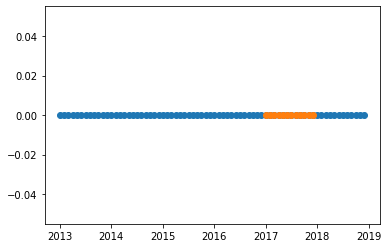

In [6]:
plt.plot(time[nmonth-72:],sic[nmonth-72:,num_x,num_y],'-o')
plt.plot(time_train[nmonth-24:nmonth-12],sic_train[nmonth-24:nmonth-12,num_x,num_y],'-o')

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
                # find the end of this pattern
                end_ix = i + n_steps
                # check if we are beyond the sequence
                if end_ix > len(sequence)-1:
                        break
                # gather input and output parts of the pattern
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                X.append(seq_x)
                y.append(seq_y)
        return array(X), array(y)

def mlp_sequence_sic(sic, n_steps, dense_num, epoch_num):
        X = list()
        if any(np.isnan(sic)):
            for i in range(n_steps):
                X_new = float("nan")
                X.append(X_new)
                #print(X_new.shape)
            RMSE = float("nan")
        else:
            if min(sic) == max(sic):
                for i in range(n_steps):
                    X_new = min(sic)
                    X.append(X_new)
                    #print(X_new.shape)
                RMSE = float("nan")
            else:     
                nmonth          = len(sic)
                sic_train       = sic[0:nmonth-n_steps]
                X_SIC, Y_SIC    = split_sequence(sic_train,n_steps)
                model = Sequential()
                model.add(Dense(dense_num, activation='relu', input_dim=n_steps))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_SIC, Y_SIC, epochs=epoch_num, verbose=0)
        
        
                for i in range(n_steps):
                    x_input = sic[nmonth-n_steps*2+i:nmonth-n_steps+i]
                    #print(time[nmonth-n_steps*2+i:nmonth-n_steps+i])
                    x_input = x_input.reshape((1, n_steps))
                    #print(x_input)
                    X_new = model.predict(x_input, verbose=0)
                    #print('sic            at ', i,'is ', sic[nmonth-n_steps+i])
                    #print('sic prediction at ', i,'is ', X_new)
                    #print('')
                    #input('press return to continue')
                    X.append(X_new[0,0])
                RMSE = sqrt(mean_squared_error(sic[nmonth-n_steps:], X))
        return array(X), RMSE
    
def AR_sequence_sic(sic, n_steps, lagnum):
        X = list()
        if any(np.isnan(sic)):
            for i in range(n_steps):
                X_new = float("nan")
                X.append(X_new)
                #print(X_new.shape)
            RMSE = float("nan")
        else:
            if min(sic) == max(sic):
                for i in range(n_steps):
                    X_new = min(sic)
                    X.append(X_new)
                    #print(X_new.shape)
                RMSE = float("nan")
            else:     
                for i in range(n_steps):
                    sic_train = sic[0:nmonth-n_steps+i]
                    model = AutoReg(sic_train, lags=lagnum)
                    model_fit = model.fit()
                    X_new = model_fit.predict(start=len(sic_train), end=len(sic_train), dynamic=False)
                    #print('sic            at ', i,'is ', sic[nmonth-n_steps+i])
                    #print('sic prediction at ', i,'is ', X_new)
                    #print('')
                    #input('press return to continue')
                    X.append(X_new)
                RMSE = sqrt(mean_squared_error(sic[nmonth-n_steps:], X))
        return array(X), RMSE

In [8]:
for ix in range(sic.shape[1]):
    for jy in range(sic.shape[2]):
        y_hat, RMSE_ML[ix,jy] = mlp_sequence_sic(sic[:,ix,jy],12,500,200)
        z_hat, RMSE_AR[ix,jy] = AR_sequence_sic(sic[:,ix,jy],12,24)
        RMSE_ML_AR[ix,jy] = RMSE_ML[ix,jy] - RMSE_AR[ix,jy]
        if (not np.isnan(RMSE_ML[ix,jy])):
            print('ix=',ix,'jy=',jy)
            print('RMSE_ML=',round(RMSE_ML[ix,jy]),'RMSE_AR=',round(RMSE_AR[ix,jy]),'ML-AR=',round(RMSE_ML_AR[ix,jy]))
            print('')

ix= 2 jy= 25
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 2 jy= 27
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= 0.0

ix= 2 jy= 28
RMSE_ML= 10.0 RMSE_AR= 9.0 ML-AR= 1.0

ix= 2 jy= 29
RMSE_ML= 16.0 RMSE_AR= 15.0 ML-AR= 1.0

ix= 3 jy= 14
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 3 jy= 23
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 3 jy= 25
RMSE_ML= 0.0 RMSE_AR= 1.0 ML-AR= -0.0

ix= 3 jy= 26
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 3 jy= 27
RMSE_ML= 8.0 RMSE_AR= 6.0 ML-AR= 1.0

ix= 3 jy= 28
RMSE_ML= 11.0 RMSE_AR= 12.0 ML-AR= -2.0

ix= 3 jy= 29
RMSE_ML= 19.0 RMSE_AR= 13.0 ML-AR= 6.0

ix= 3 jy= 30
RMSE_ML= 2.0 RMSE_AR= 1.0 ML-AR= 1.0

ix= 4 jy= 14
RMSE_ML= 5.0 RMSE_AR= 3.0 ML-AR= 3.0

ix= 4 jy= 15
RMSE_ML= 5.0 RMSE_AR= 3.0 ML-AR= 1.0

ix= 4 jy= 16
RMSE_ML= 2.0 RMSE_AR= 2.0 ML-AR= -0.0

ix= 4 jy= 17
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 4 jy= 20
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 4 jy= 21
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 4 jy= 22
RMSE_ML= 2.0 RMSE_AR= 4.0 ML-AR= -3.0

ix= 4 jy= 25


ix= 18 jy= 7
RMSE_ML= 9.0 RMSE_AR= 8.0 ML-AR= 1.0

ix= 18 jy= 10
RMSE_ML= 5.0 RMSE_AR= 7.0 ML-AR= -2.0

ix= 18 jy= 11
RMSE_ML= 15.0 RMSE_AR= 13.0 ML-AR= 2.0

ix= 18 jy= 12
RMSE_ML= 8.0 RMSE_AR= 7.0 ML-AR= 2.0

ix= 18 jy= 13
RMSE_ML= 4.0 RMSE_AR= 3.0 ML-AR= 1.0

ix= 18 jy= 15
RMSE_ML= 3.0 RMSE_AR= 3.0 ML-AR= 0.0

ix= 18 jy= 16
RMSE_ML= 1.0 RMSE_AR= 0.0 ML-AR= 0.0

ix= 18 jy= 17
RMSE_ML= 1.0 RMSE_AR= 1.0 ML-AR= 0.0

ix= 18 jy= 18
RMSE_ML= 1.0 RMSE_AR= 1.0 ML-AR= 0.0

ix= 18 jy= 19
RMSE_ML= 2.0 RMSE_AR= 2.0 ML-AR= 1.0

ix= 18 jy= 20
RMSE_ML= 3.0 RMSE_AR= 3.0 ML-AR= -0.0

ix= 18 jy= 21
RMSE_ML= 25.0 RMSE_AR= 22.0 ML-AR= 3.0

ix= 18 jy= 22
RMSE_ML= 10.0 RMSE_AR= 10.0 ML-AR= -1.0

ix= 18 jy= 23
RMSE_ML= 14.0 RMSE_AR= 15.0 ML-AR= -1.0

ix= 18 jy= 24
RMSE_ML= 13.0 RMSE_AR= 12.0 ML-AR= 1.0

ix= 19 jy= 4
RMSE_ML= 3.0 RMSE_AR= 5.0 ML-AR= -2.0

ix= 19 jy= 5
RMSE_ML= 14.0 RMSE_AR= 18.0 ML-AR= -4.0

ix= 19 jy= 6
RMSE_ML= 9.0 RMSE_AR= 10.0 ML-AR= -1.0

ix= 19 jy= 11
RMSE_ML= 12.0 RMSE_AR= 12.0 ML-AR=

ix= 31 jy= 3
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 31 jy= 4
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 31 jy= 19
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 31 jy= 23
RMSE_ML= 0.0 RMSE_AR= 1.0 ML-AR= -0.0

ix= 32 jy= 20
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 32 jy= 21
RMSE_ML= 1.0 RMSE_AR= 1.0 ML-AR= -0.0

ix= 32 jy= 23
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0

ix= 33 jy= 21
RMSE_ML= 1.0 RMSE_AR= 1.0 ML-AR= -0.0

ix= 33 jy= 22
RMSE_ML= 0.0 RMSE_AR= 0.0 ML-AR= -0.0



In [9]:
#nc_fid.createDimension('num_pixels',10)
#nc_fid.createDimension('num_lines', 10)
ARvariable = nc_fid.createVariable('RMSE_AR', 'float',('num_pixels', 'num_lines'))
MLvariable = nc_fid.createVariable('RMSE_ML', 'float',('num_pixels', 'num_lines'))
ML_AR      = nc_fid.createVariable('RMSE_ML_AR', 'float',('num_pixels', 'num_lines'))
ARvariable[:] = RMSE_AR[:,:]
MLvariable[:] = RMSE_ML[:,:]
ML_AR[:]      = RMSE_ML_AR[:,:]
nc_fid.close()
print('Average of RMSE with MLP = ', round(nanmean(RMSE_ML)))
print('Average of RMSE with Autoregression = ', round(nanmean(RMSE_AR)))

Average of RMSE with MLP =  9.0
Average of RMSE with Autoregression =  9.0
